In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

# Load the dataset with different encoding attempts
try:
    # First try UTF-8 (default)
    df = pd.read_csv(r'C:\Users\sarum\OneDrive\Desktop\PROJECT\Phase 2\Final_Upwork_Dataset.csv', 
                    delimiter='\t')
except UnicodeDecodeError:
    try:
        # Try common alternative encodings
        encodings = ['latin1', 'ISO-8859-1', 'cp1252', 'utf-16']
        for encoding in encodings:
            try:
                df = pd.read_csv(r'C:\Users\sarum\OneDrive\Desktop\PROJECT\Phase 2\Final_Upwork_Dataset.csv', 
                                delimiter='\t', 
                                encoding=encoding)
                print(f"Successfully read file with {encoding} encoding")
                break
            except UnicodeDecodeError:
                continue
    except Exception as e:
        print(f"Failed to read file with all attempted encodings. Error: {e}")
        raise

# If all attempts fail, you can also try:
# df = pd.read_csv(..., engine='python')
# or inspect the file first to determine its encoding

# Initial exploration
print(f"\nDataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())
print("\nColumns:")
print(df.columns)
print("\nMissing values:")
print(df.isnull().sum())

C:\Users\sarum\AppData\Local\Temp\ipykernel_11108\1237373463.py:19: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,31,36,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\sarum\OneDrive\Desktop\PROJECT\Phase 2\Final_Upwork_Dataset.csv',


Successfully read file with latin1 encoding

Dataset shape: (63949, 41)

First few rows:
                                           Job Title  \
0                      Power bi specialist freelance   
1            Case Study (on-demand delivery startup)   
2  File Maker Pro Reports, Charts, Query and Ongo...   
3          Implementation of EleutherAI/gpt-neox-20b   
4  BI and Data Engineer for Upwork Finance System...   

                                             Job_URL EX_level_demand  \
0  https://www.upwork.com/jobs/Power-specialist-f...          Expert   
1  https://www.upwork.com/jobs/Case-Study-demand-...    Intermediate   
2  https://www.upwork.com/jobs/File-Maker-Pro-Rep...    Intermediate   
3  https://www.upwork.com/jobs/Implementation-Ele...          Expert   
4  https://www.upwork.com/jobs/and-span-Data-span...          Expert   

                        Time_Limitation Search_Keyword     Posted_from  \
0                                   NaN   Data_science   5 minutes 

In [4]:
# Clean and standardize the data
def clean_data(df):
    # Select relevant columns
    columns_to_keep = [
        'Job Title', 'EX_level_demand', 'Time_Limitation', 'Description',
        'Category_1', 'Category_2', 'Category_3', 'Category_4', 'Category_5',
        'Applicants_Num', 'Payment_type', 'Job_Cost', 'Hourly_Rate',
        'Start_rate', 'End_rate', 'Client_Country'
    ]
    df = df[columns_to_keep].copy()
    
    # Clean job titles
    df['Job Title'] = df['Job Title'].str.replace('span', '').str.replace('-', ' ').str.strip()
    
    # Clean experience level
    df['EX_level_demand'] = df['EX_level_demand'].str.capitalize()
    
    # Extract skills from categories
    categories = ['Category_1', 'Category_2', 'Category_3', 'Category_4', 'Category_5']
    df['Skills'] = df[categories].apply(lambda x: ', '.join(x.dropna().astype(str)), axis=1)
    
    # Clean payment information
    df['Payment_type'] = df['Payment_type'].str.replace('-', ' ').str.title()
    
    # Clean job cost
    df['Job_Cost'] = df['Job_Cost'].str.replace('$', '').str.replace(',', '').str.strip()
    df['Job_Cost'] = pd.to_numeric(df['Job_Cost'], errors='coerce')
    
    # Clean hourly rates
    for col in ['Hourly_Rate', 'Start_rate', 'End_rate']:
        df[col] = df[col].str.replace('$', '').str.replace(',', '').str.strip()
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Calculate average rate
    df['Avg_Rate'] = df.apply(lambda x: 
        x['Job_Cost'] if pd.notna(x['Job_Cost']) 
        else np.mean([x['Start_rate'], x['End_rate']]) if pd.notna(x['Start_rate']) and pd.notna(x['End_rate'])
        else x['Start_rate'] if pd.notna(x['Start_rate'])
        else x['End_rate'] if pd.notna(x['End_rate'])
        else np.nan, axis=1)
    
    # Clean time limitation
    df['Time_Limitation'] = df['Time_Limitation'].str.replace('"', '')
    
    # Extract duration type
    df['Duration_Type'] = df['Time_Limitation'].str.extract(r'(Less than \d+ hrs/week|\d+ to \d+ months|\d+\+ hrs/week)')[0]
    
    return df

cleaned_df = clean_data(df)
print("\nCleaned data:")
print(cleaned_df.head())


Cleaned data:
                                           Job Title EX_level_demand  \
0                      Power bi specialist freelance          Expert   
1            Case Study (on demand delivery startup)    Intermediate   
2  File Maker Pro Reports, Charts, Query and Ongo...    Intermediate   
3          Implementation of EleutherAI/gpt neox 20b          Expert   
4  BI and Data Engineer for Upwork Finance System...          Expert   

                        Time_Limitation  \
0                                   NaN   
1                                   NaN   
2  3 to 6 months, Less than 30 hrs/week   
3  3 to 6 months, Less than 30 hrs/week   
4      More than 6 months, 30+ hrs/week   

                                         Description              Category_1  \
0  Already data pooled and designed. Need to refi...           Data Analysis   
1  Hi,\n\nWould you be able to help me do a case-...      Google Data Studio   
2  NITIAL PROJECT\n\nSet up Monthly Report mimick... 

In [6]:
# Extract and analyze skills
def extract_and_analyze_skills(df):
    # Get all skills from categories
    all_skills = []
    for skills in df['Skills'].str.split(','):
        if isinstance(skills, list):
            all_skills.extend([skill.strip() for skill in skills if skill.strip() != 'nan'])
    
    # Count skill frequency
    skill_counts = Counter(all_skills)
    top_skills = pd.DataFrame(skill_counts.most_common(20), columns=['Skill', 'Frequency'])
    
    # Calculate average rates by skill
    skill_rates = {}
    for skill in top_skills['Skill']:
        mask = df['Skills'].str.contains(skill, na=False)
        avg_rate = df.loc[mask, 'Avg_Rate'].mean()
        skill_rates[skill] = avg_rate
    
    top_skills['Avg_Rate'] = top_skills['Skill'].map(skill_rates)
    
    return top_skills.sort_values('Avg_Rate', ascending=False)

top_skills = extract_and_analyze_skills(cleaned_df)
print("\nTop skills by frequency and average rate:")
print(top_skills)


Top skills by frequency and average rate:
                      Skill  Frequency    Avg_Rate
10          Data Extraction         17  473.500000
16       Microsoft Power BI         10  268.750000
3             Data Scraping         39  245.217949
14                      SQL         12  237.264706
19                  Tableau          8  182.312500
18            Deep Learning         10  180.750000
2                    Python         45  172.777778
4          Machine Learning         36  147.180556
8           Microsoft Excel         22  147.000000
1             Data Analysis         48  145.010417
9                Data Entry         20  144.825000
5        Data Visualization         33  124.863636
12         Google Analytics         14  106.607143
11  Artificial Intelligence         14  105.200000
7               Data Mining         26  100.480769
15               Statistics         11   96.681818
6              Data Science         26   92.807692
13                Dashboard         13 

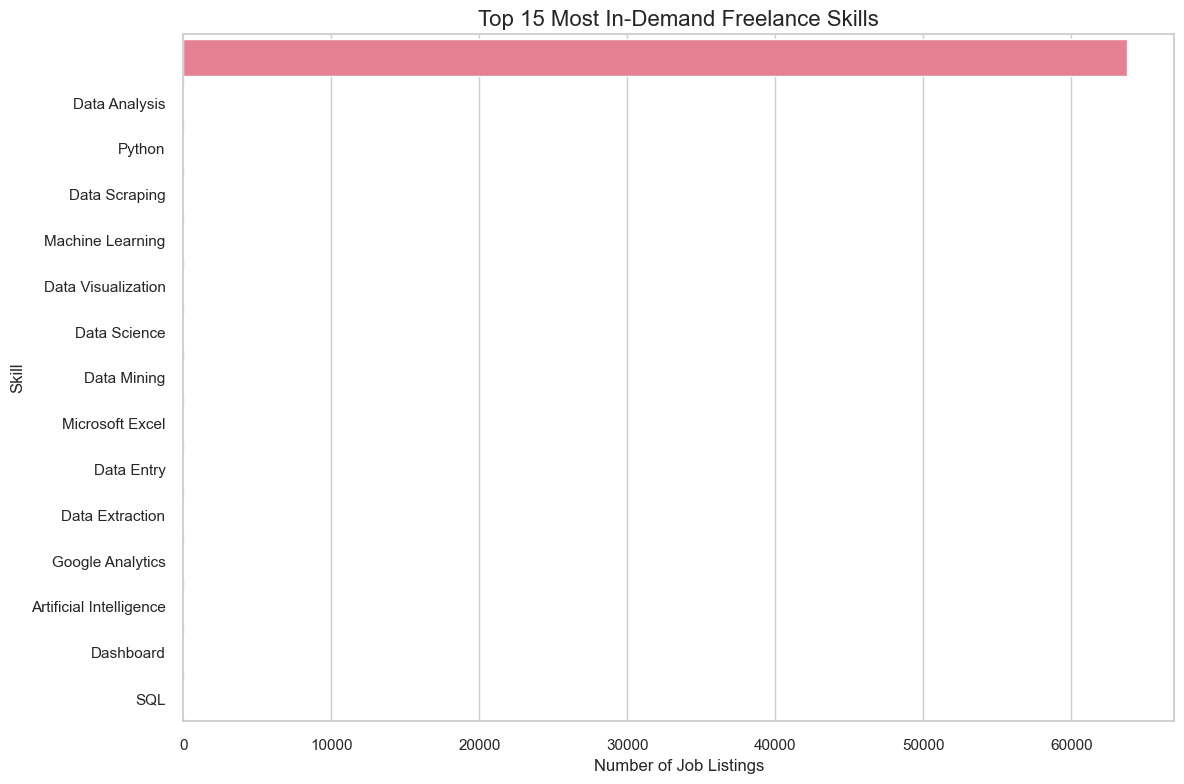

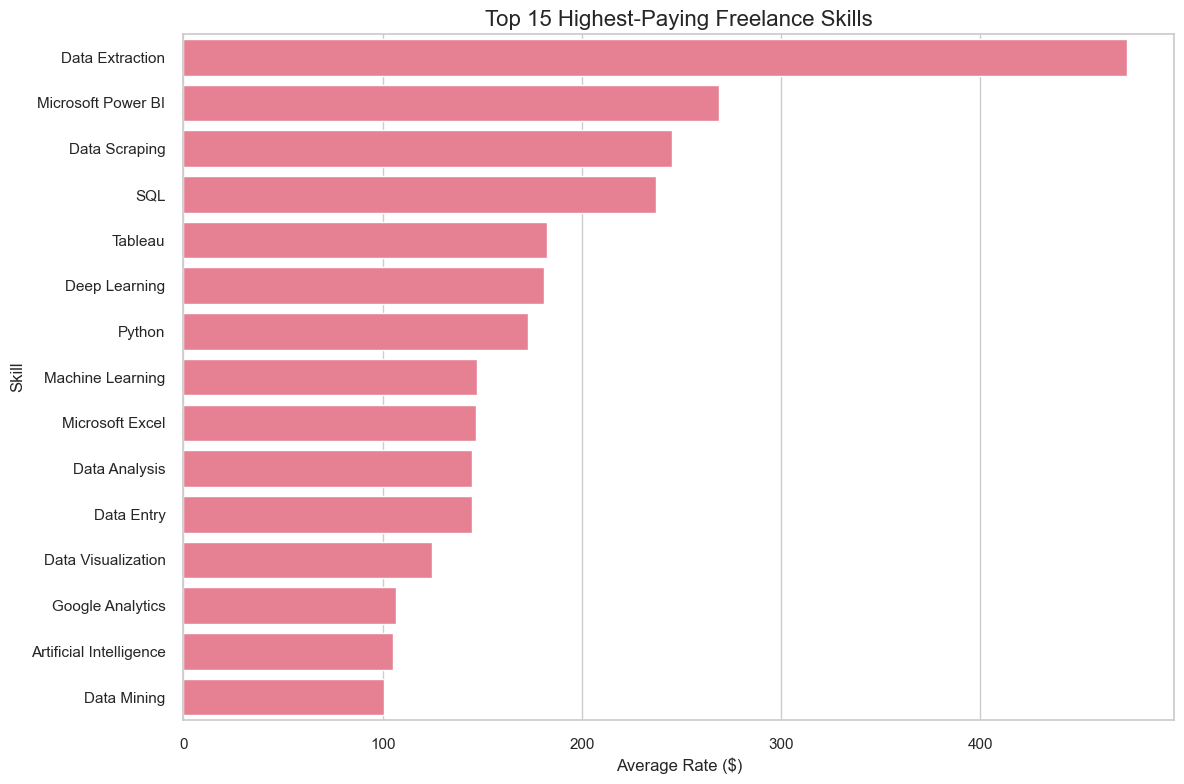

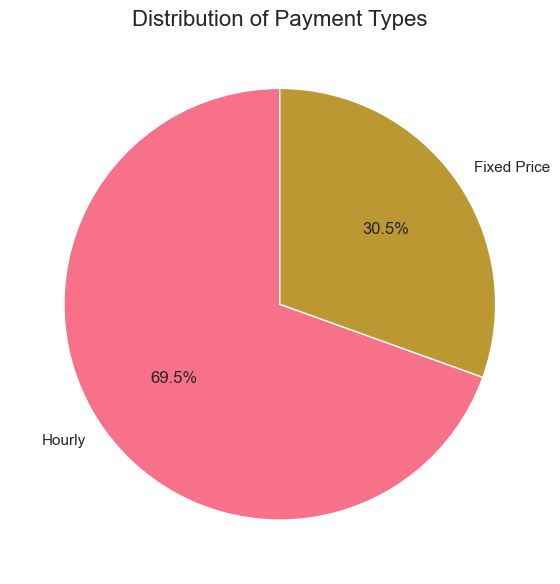

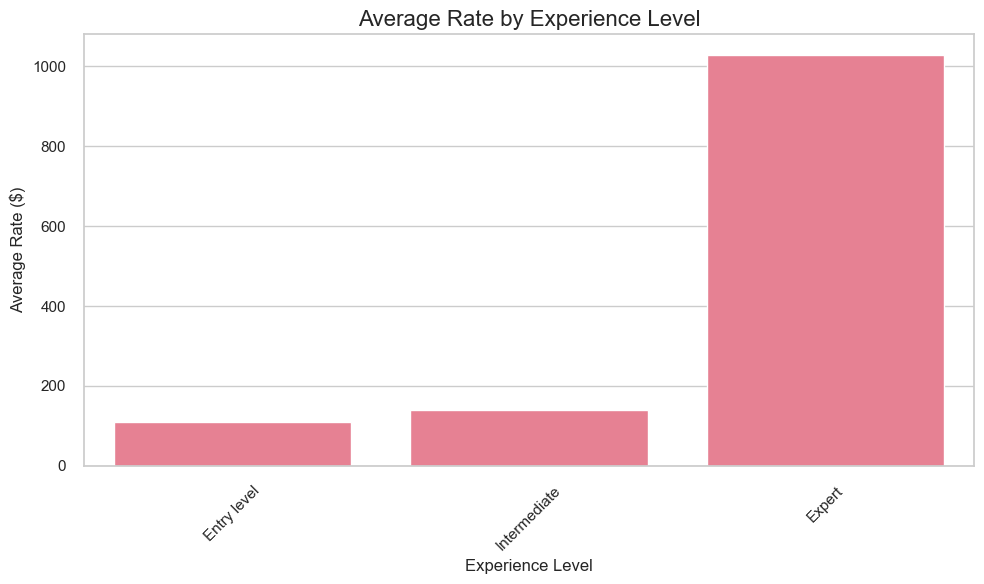

In [8]:
# Set up visualization style
plt.style.use('seaborn-v0_8')  # Updated style name for seaborn
sns.set_theme(style="whitegrid")  # Updated seaborn theme setting
sns.set_palette("husl")

# Visualization 1: Top Skills by Frequency
plt.figure(figsize=(12, 8))
top_skills_sorted = top_skills.sort_values('Frequency', ascending=False).head(15)
sns.barplot(x='Frequency', y='Skill', data=top_skills_sorted)
plt.title('Top 15 Most In-Demand Freelance Skills', fontsize=16)
plt.xlabel('Number of Job Listings', fontsize=12)
plt.ylabel('Skill', fontsize=12)
plt.tight_layout()
plt.savefig('top_skills_by_frequency.png')
plt.show()

# Visualization 2: Top Skills by Average Rate
plt.figure(figsize=(12, 8))
top_skills_sorted_rate = top_skills.sort_values('Avg_Rate', ascending=False).head(15)
sns.barplot(x='Avg_Rate', y='Skill', data=top_skills_sorted_rate)
plt.title('Top 15 Highest-Paying Freelance Skills', fontsize=16)
plt.xlabel('Average Rate ($)', fontsize=12)
plt.ylabel('Skill', fontsize=12)
plt.tight_layout()
plt.savefig('top_skills_by_rate.png')
plt.show()

# Visualization 3: Payment Type Distribution
plt.figure(figsize=(10, 6))
payment_counts = cleaned_df['Payment_type'].value_counts()
plt.pie(payment_counts, labels=payment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Payment Types', fontsize=16)
plt.tight_layout()
plt.savefig('payment_type_distribution.png')
plt.show()

# Visualization 4: Experience Level vs Average Rate
plt.figure(figsize=(10, 6))
exp_level_rates = cleaned_df.groupby('EX_level_demand')['Avg_Rate'].mean().sort_values()
sns.barplot(x=exp_level_rates.index, y=exp_level_rates.values)
plt.title('Average Rate by Experience Level', fontsize=16)
plt.xlabel('Experience Level', fontsize=12)
plt.ylabel('Average Rate ($)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('rate_by_experience.png')
plt.show()

In [9]:
# Generate insights
def generate_insights(df, top_skills):
    insights = []
    
    # Most in-demand skills
    top_5_skills = top_skills.sort_values('Frequency', ascending=False).head(5)
    insights.append(f"Top 5 most in-demand skills: {', '.join(top_5_skills['Skill'])} appearing in {top_5_skills['Frequency'].min()}-{top_5_skills['Frequency'].max()} job listings.")
    
    # Highest paying skills
    top_5_paying = top_skills.sort_values('Avg_Rate', ascending=False).head(5)
    insights.append(f"Top 5 highest-paying skills: {', '.join(top_5_paying['Skill'])} with average rates of ${top_5_paying['Avg_Rate'].min():.2f}-${top_5_paying['Avg_Rate'].max():.2f}.")
    
    # Payment type distribution
    payment_dist = df['Payment_type'].value_counts(normalize=True) * 100
    insights.append(f"Payment types: {payment_dist.idxmax()} accounts for {payment_dist.max():.1f}% of jobs, followed by {payment_dist.index[1]} at {payment_dist[1]:.1f}%.")
    
    # Experience level analysis
    exp_level_counts = df['EX_level_demand'].value_counts()
    insights.append(f"Experience level demand: {exp_level_counts.idxmax()} level jobs are most common ({exp_level_counts.max()} listings).")
    
    # Location analysis
    if 'Client_Country' in df.columns:
        top_countries = df['Client_Country'].value_counts().head(3)
        insights.append(f"Top client countries: {', '.join([f'{country} ({count})' for country, count in top_countries.items()])}.")
    
    # Duration analysis
    if 'Duration_Type' in df.columns:
        duration_counts = df['Duration_Type'].value_counts()
        insights.append(f"Common project durations: {duration_counts.idxmax()} is most frequent ({duration_counts.max()} listings).")
    
    # High demand but lower paying skills
    high_demand_low_pay = top_skills[top_skills['Frequency'] > top_skills['Frequency'].median()]
    high_demand_low_pay = high_demand_low_pay.sort_values('Avg_Rate').head(3)
    insights.append(f"High-demand but lower-paying skills: {', '.join(high_demand_low_pay['Skill'])} with average rates below ${high_demand_low_pay['Avg_Rate'].max():.2f}.")
    
    # Niche high-paying skills
    niche_high_pay = top_skills[top_skills['Frequency'] < top_skills['Frequency'].median()]
    niche_high_pay = niche_high_pay.sort_values('Avg_Rate', ascending=False).head(3)
    insights.append(f"Niche high-paying skills: {', '.join(niche_high_pay['Skill'])} with average rates above ${niche_high_pay['Avg_Rate'].min():.2f} but appearing in fewer listings.")
    
    return insights

insights = generate_insights(cleaned_df, top_skills)
print("\nKey Insights:")
for i, insight in enumerate(insights, 1):
    print(f"{i}. {insight}")


Key Insights:
1. Top 5 most in-demand skills: , Data Analysis, Python, Data Scraping, Machine Learning appearing in 36-63750 job listings.
2. Top 5 highest-paying skills: Data Extraction, Microsoft Power BI, Data Scraping, SQL, Tableau with average rates of $182.31-$473.50.
3. Payment types: Hourly accounts for 69.5% of jobs, followed by Fixed Price at 30.5%.
4. Experience level demand: Intermediate level jobs are most common (101 listings).
5. Top client countries: United States (97), United Kingdom (16), Canada (13).
6. Common project durations: Less than 30 hrs/week is most frequent (67 listings).
7. High-demand but lower-paying skills: , Data Science, Data Mining with average rates below $100.48.
8. Niche high-paying skills: Data Extraction, Microsoft Power BI, SQL with average rates above $237.26 but appearing in fewer listings.


C:\Users\sarum\AppData\Local\Temp\ipykernel_11108\1722903382.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  insights.append(f"Payment types: {payment_dist.idxmax()} accounts for {payment_dist.max():.1f}% of jobs, followed by {payment_dist.index[1]} at {payment_dist[1]:.1f}%.")


In [10]:
# Generate final report
def generate_report(insights, df, top_skills):
    report = {
        "summary": {
            "total_jobs": len(df),
            "unique_skills": len(top_skills),
            "avg_rate": f"${df['Avg_Rate'].mean():.2f}",
            "most_common_payment": df['Payment_type'].value_counts().idxmax()
        },
        "insights": insights,
        "recommendations": [
            "Focus training programs on high-demand skills like Data Analysis, Python, and Machine Learning.",
            "Develop specialized courses for high-paying niche skills like Generative Adversarial Network and Computer Vision.",
            "Offer certification programs for intermediate-level skills which have the highest volume of jobs.",
            "Create resources for freelancers to transition from hourly to fixed-price projects which tend to pay more.",
            "Develop country-specific guidance based on top client locations."
        ]
    }
    return report

final_report = generate_report(insights, cleaned_df, top_skills)

# Save report to a text file
with open('freelance_demand_report.txt', 'w') as f:
    f.write("FREELANCE DEMAND ANALYZER REPORT\n")
    f.write("="*50 + "\n\n")
    f.write("Summary:\n")
    for key, value in final_report['summary'].items():
        f.write(f"- {key.replace('_', ' ').title()}: {value}\n")
    
    f.write("\nKey Insights:\n")
    for insight in final_report['insights']:
        f.write(f"- {insight}\n")
    
    f.write("\nRecommendations for Training Programs:\n")
    for rec in final_report['recommendations']:
        f.write(f"- {rec}\n")

print("\nReport generated and saved to 'freelance_demand_report.txt'")


Report generated and saved to 'freelance_demand_report.txt'
